In [51]:
# Import libraries

import datetime
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sns.set_theme(style="whitegrid")

In [10]:
# Read dataframe and drop duplicates

FILEPATHS = [
    'data/uvalde_reddit_500k.csv'
]

df = pd.concat([pd.read_csv(filepath) for filepath in FILEPATHS])
df = df.drop_duplicates(subset=['text'])

/home/alper/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


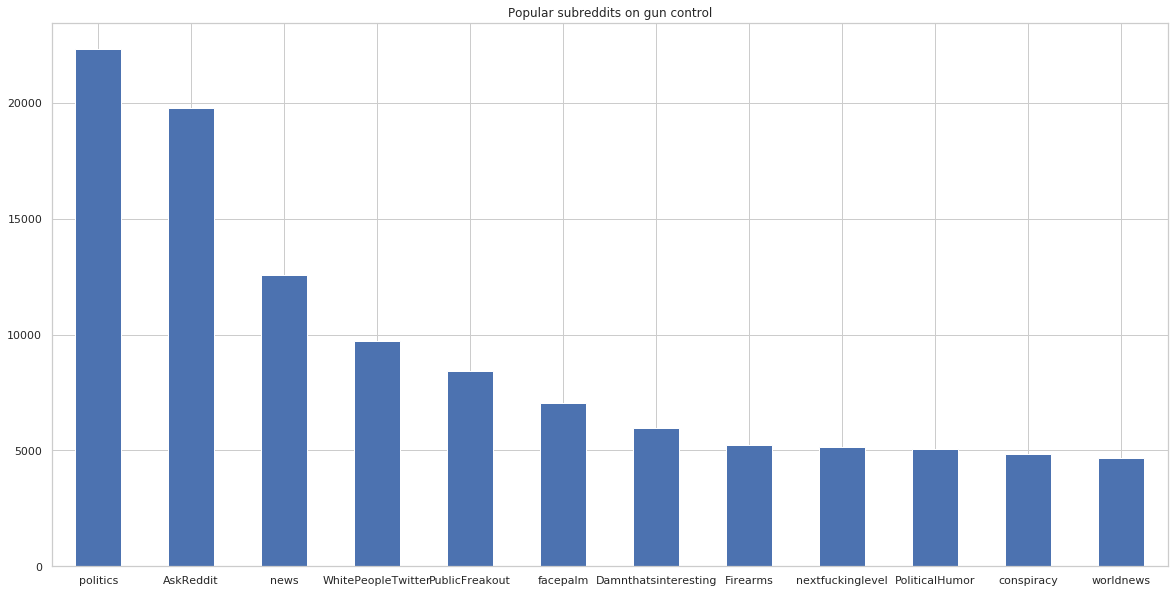

In [11]:
# Plot popular subreddits

df['subreddit'].value_counts()[:12].plot.bar(
    rot=0,
    title="Popular subreddits on gun control",
    figsize=(20,10)
)

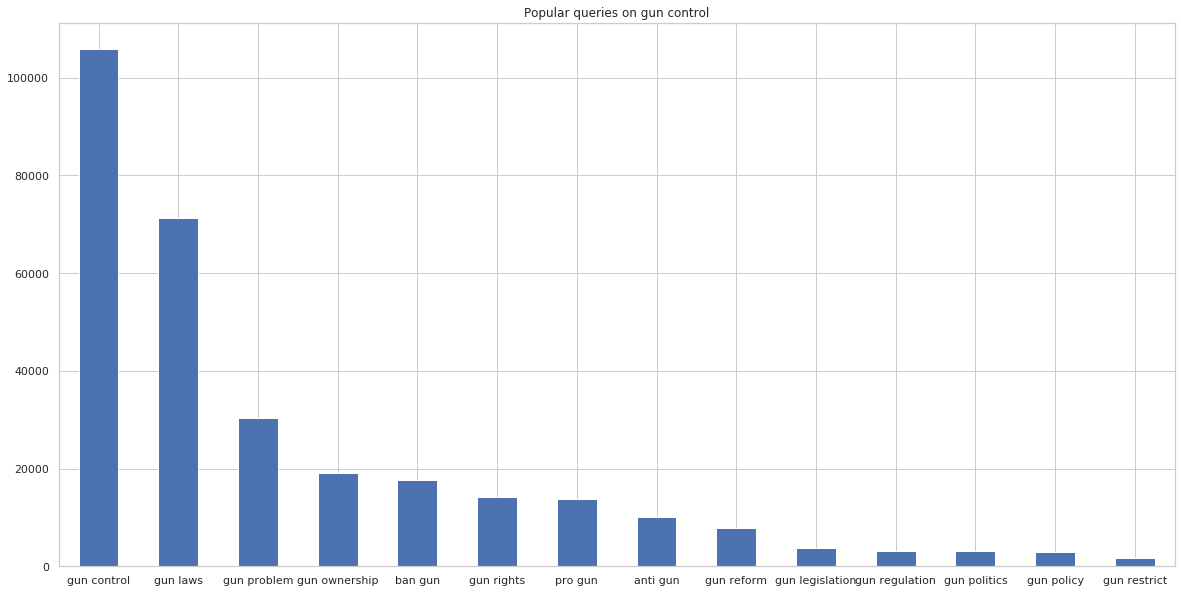

In [12]:
# Plot popular queries

df['query'].value_counts()[:15].plot.bar(
    rot=0,
    title="Popular queries on gun control",
    figsize=(20,10)
)

In [13]:
start_date = datetime.datetime(2022, 5, 17, 0, 0)
day_count = 21
intervals = [start_date + datetime.timedelta(days=n) for n in range(day_count + 1)]
dates = [interval.strftime("%d-%m-%Y") for interval in intervals]

intervals_comments = list()

for i in range(len(intervals)-1):
    df_between = df[(df.created_at > intervals[i].timestamp()) &
      (df.created_at < intervals[i+1].timestamp())]
    num_comments = len(df_between)
    intervals_comments.append(num_comments)
    

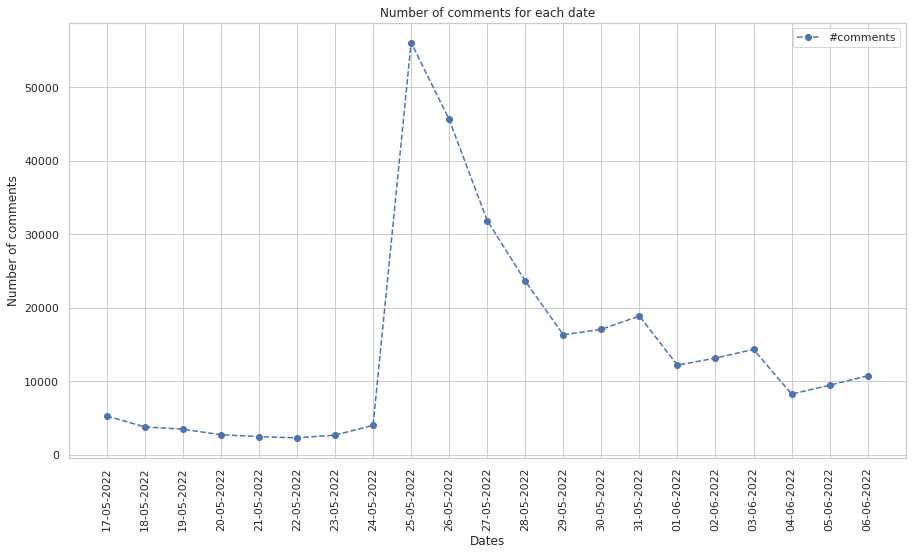

In [14]:
# Plot number of comments for each date

xi = list(range(len(dates[:-1])))

plt.figure(figsize=(15,8))
plt.plot(xi, intervals_comments, marker='o', linestyle='--', color='b', label='#comments') 
plt.xticks(xi, dates[:-1], rotation=90)
plt.legend()

plt.title('Number of comments for each date')
plt.xlabel('Dates')
plt.ylabel('Number of comments')

plt.show()

In [19]:
def get_tokens(df: pd.DataFrame):
    all_tokens = []

    for row in df.itertuples():
        row_split = row.text.split()
        tokens = [token.lower() for token in row_split]
        
        all_tokens += " ".join(tokens) + " "

    return all_tokens

In [28]:
# Separate dataframe into liberal, conservative, moderate

shooting_date = datetime.datetime(2022, 5, 17, 0, 0).timestamp()

df_liberal = df[df['subreddit'].str.contains("liberal", na=False)]
df_conservative = df[df['subreddit'].str.contains("conservative", na=False)]
df_moderate = df[df['subreddit'].str.contains("moderate", na=False)]

df_liberal_before = df_liberal[df_liberal.created_at < shooting_date]
df_conservative_before = df_conservative[df_conservative.created_at < shooting_date]
df_moderate_before = df_moderate[df_moderate.created_at < shooting_date]

df_liberal_after = df_liberal[df_liberal.created_at > shooting_date]
df_conservative_after = df_conservative[df_conservative.created_at > shooting_date]
df_moderate_after = df_moderate[df_moderate.created_at > shooting_date]

tokens_liberal = get_tokens(df_liberal)
tokens_conservative = get_tokens(df_conservative)
tokens_moderate = get_tokens(df_moderate)

tokens_liberal_before = get_tokens(df_liberal_before)
tokens_conservative_before = get_tokens(df_conservative_before)
tokens_moderate_before = get_tokens(df_moderate_before)

tokens_liberal_after = get_tokens(df_liberal_after)
tokens_conservative_after = get_tokens(df_conservative_after)
tokens_moderate_after = get_tokens(df_moderate_after)

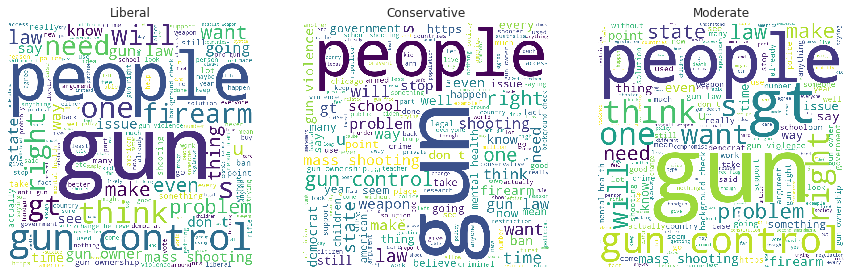

In [49]:
# Word cloud (liberal)

fig = plt.figure(figsize=(15,15), facecolor=None)

ax = fig.add_subplot(131)
wordcloud = WordCloud(
            width=800,
            height=800,
            background_color='white',
            stopwords=set(STOPWORDS),
            min_font_size=10).generate(tokens_liberal)
ax.title.set_text('Liberal')
ax.imshow(wordcloud)
ax.axis("off")

ax2 = fig.add_subplot(132)
wordcloud = WordCloud(
            width=800,
            height=800,
            background_color='white',
            stopwords=set(STOPWORDS),
            min_font_size=10).generate(tokens_conservative)
ax2.title.set_text('Conservative')
ax2.imshow(wordcloud)
ax2.axis("off")

ax3 = fig.add_subplot(133)
wordcloud = WordCloud(
            width=800,
            height=800,
            background_color='white',
            stopwords=set(STOPWORDS),
            min_font_size=10).generate(tokens_moderate)
ax3.title.set_text('Moderate')
ax3.imshow(wordcloud)
ax3.axis("off")
#ax.tight_layout(pad=0)

 
plt.show()

In [52]:
nltk.download("vader_lexicon")

def predict_sentiment(scores):
    return 1 if scores["pos"] >= scores["neg"] else 0

def analyze_sentiment(comments):
    sid = SentimentIntensityAnalyzer()

    sentiments = [predict_sentiment(sid.polarity_scores(comment))
                  for comment in comments]

    return sentiments

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alper/nltk_data...


In [56]:
# Get sentiments

sentiments_liberal = analyze_sentiment(df_liberal.text.tolist())
sentiments_conservative = analyze_sentiment(df_conservative.text.tolist())
sentiments_moderate = analyze_sentiment(df_moderate.text.tolist())

pos_liberal = sum(sentiments_liberal)
neg_liberal = len(sentiments_liberal) - sum(sentiments_liberal)

pos_conservative = sum(sentiments_conservative)
neg_conservative = len(sentiments_conservative) - sum(sentiments_conservative)

pos_moderate = sum(sentiments_moderate)
neg_moderate = len(sentiments_moderate) - sum(sentiments_moderate)


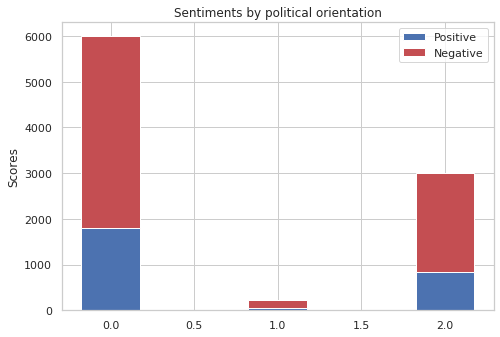

In [58]:
N = 3

pos_comments = (pos_liberal, pos_conservative, pos_moderate)
neg_comments = (neg_liberal, neg_conservative, neg_moderate)

ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, pos_comments, width, color='b')
ax.bar(ind, neg_comments, width,bottom=pos_comments, color='r')
ax.set_ylabel('Scores')
ax.set_title('Sentiments by political orientation')
ax.set_xticks(ind, ('L', 'C', 'M'))
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Positive', 'Negative'])
plt.show()